# Explore here

In [1]:
# lectura de los datos
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [2]:
#cambiar el formato de date a date_time
df['date'] = pd.to_datetime(df['date'])
df.info()
# convertir fecha en el indice 
df = df.set_index('date')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    366 non-null    datetime64[ns]
 1   sales   366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


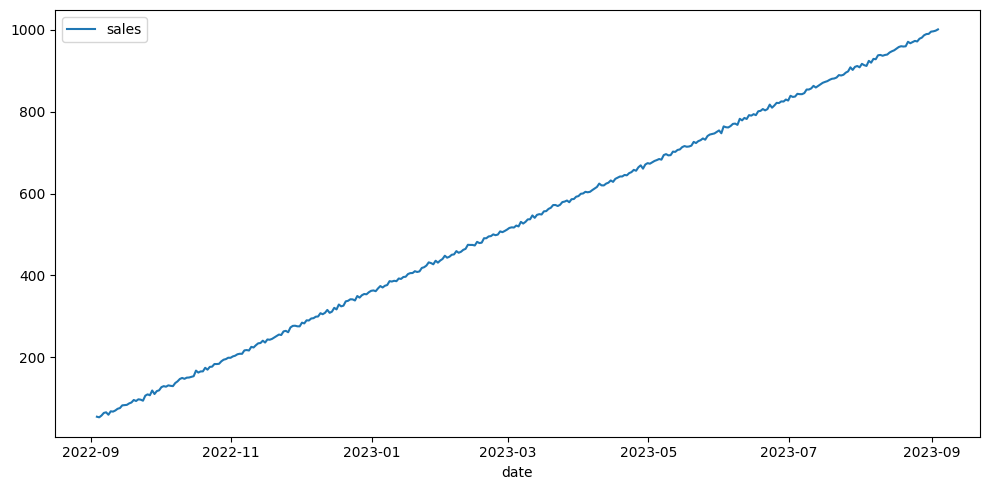

In [3]:
#graficar la serie de tiempo
import matplotlib.pyplot as plt
import seaborn as sns

#para visualizar mejor, le damos un figsize
plt.subplots(figsize=(10,5))
sns.lineplot(data=df)
plt.tight_layout()
plt.show()

Observamos una tendencia creciente, con pequeñas variaciones.

In [4]:
#descomponer la serie. el valor de period es la cantidad de observaciones que se quiere por periodo.
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df, period=30)

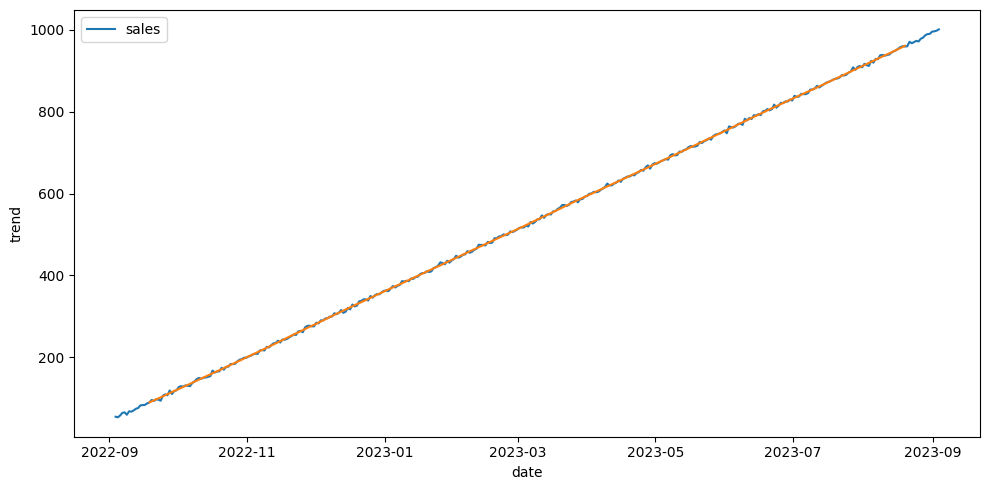

In [5]:
#graficar la tendencia sobre la serie temporal
tendencia = decomposition.trend
plt.subplots(figsize=(10,5))
sns.lineplot(data=df)
sns.lineplot(data=tendencia)
plt.tight_layout()
plt.show()

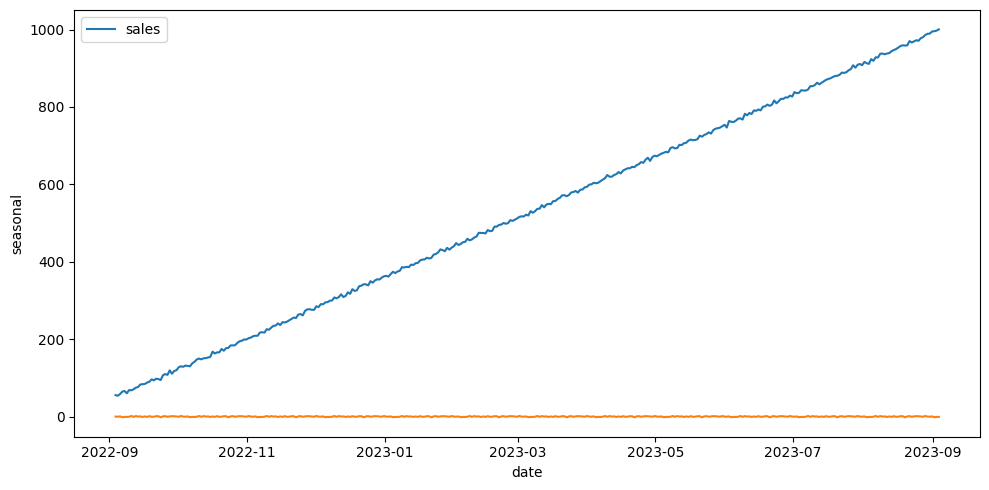

In [6]:
#graficar el componente estacional sobre la serie de tiempo
estacional = decomposition.seasonal
plt.subplots(figsize=(10,5))
sns.lineplot(data=df)
sns.lineplot(data=estacional)
plt.tight_layout()
plt.show()

el componente estacional es practicamente cero para toda la serie. No se observa comportamiento estacional importante.

In [7]:
#al evaluar con un dickey fuller podemos observar p value y conocer si es una serie estacionaria.
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

No es una serie estacionaria. Es creciente,esto lo confirma el p value de 0.98

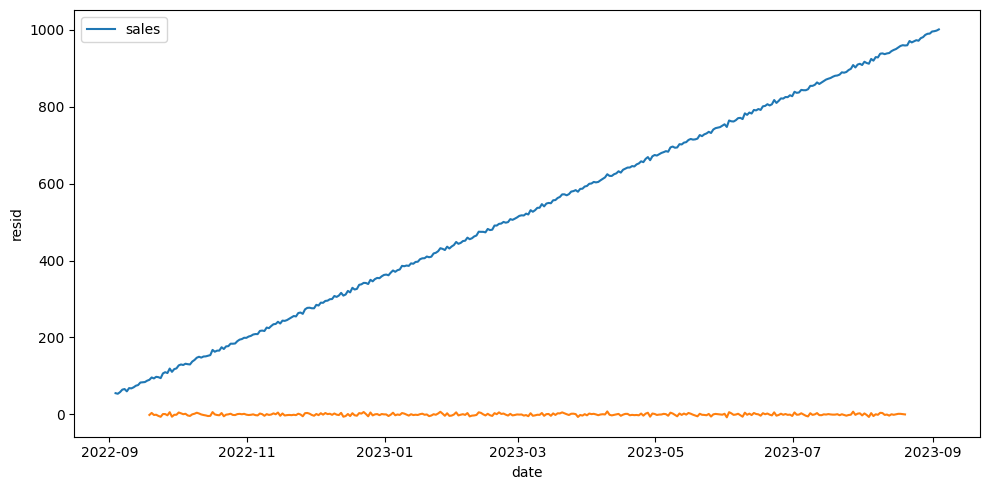

In [8]:
#analizar los residuos
residuos = decomposition.resid
plt.subplots(figsize=(10,5))
sns.lineplot(data=df)
sns.lineplot(data=residuos)
plt.tight_layout()
plt.show()

Se observan pequeños residuos.

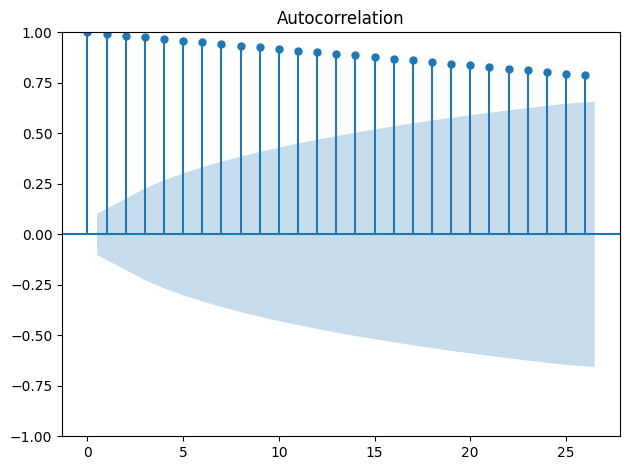

In [9]:
#analizar autocorrelacion
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df)
plt.tight_layout()
plt.show()

altisima autocorrelacion con el valor anterior. el valor siguiente depende del valor anterior

Al tener una alta autocorrelacion, podemos usar un modelo ARIMS, auto-regresivo. Para ello, como el test de dicky fuller arrojo un p value mayor a 0.05, debo 
diferenciar y por lo tanto, transformar la serie a estacionaria 

In [10]:
#transformamos la serie a estacionaria
df_stationary = df.diff().dropna()
#test estacionario
test_stationarity(df_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

obtenemos un p value muy pequeño, de 5.2 por diez elevadoa menos 16, por lo que podemos aceptar la hipotesis nula, de que es estacionaria.

In [11]:
#ahora la serie es estacionaria y podemos aplicarle el metodo ARIMA
#el seasonal es tan pequeño que lo ponemos como false
from pmdarima import auto_arima

model = auto_arima(df_stationary, seasonal=False, trace = True, m=30)

/home/vscode/.local/lib/python3.10/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (30) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1854.775, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2209.657, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2205.881, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2208.143, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1862.229, Time=0.50 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1843.049, Time=0.43 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1843.587, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1841.533, Time=0.35 sec
 A

In [12]:
#resumen del modelo
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -915.776
Date:                Mon, 10 Jun 2024   AIC                           1839.553
Time:                        19:20:49   BIC                           1855.152
Sample:                    09-04-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
#ahora hacemos un split sobre la variable tiempo, del 9 de enero de 2023 hacia atras y hacia adelante
train_df = df_stationary[df_stationary.index < pd.to_datetime('2023-07-25')]
test_df = df_stationary[df_stationary.index >= pd.to_datetime('2023-07-25')]

In [14]:
test_df

,sales
date,
2023-07-25 17:10:08.079328,5.137929
2023-07-26 17:10:08.079328,3.066615
2023-07-27 17:10:08.079328,9.845911
2023-07-28 17:10:08.079328,-6.281532
2023-07-29 17:10:08.079328,7.546623
2023-07-30 17:10:08.079328,2.014523
2023-07-31 17:10:08.079328,-3.205660
2023-08-01 17:10:08.079328,8.489334
2023-08-02 17:10:08.079328,-3.268661


In [15]:
#hacer el auto arima sobre el test de entrenamiento
model = auto_arima(train_df, seasonal=False, trace = True, m=30)

/home/vscode/.local/lib/python3.10/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (30) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1647.170, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1960.074, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1957.119, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1959.023, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1648.591, Time=0.32 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1646.552, Time=0.29 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1899.474, Time=0.07 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1923.086, Time=0.03 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1897.527, Time=0.08 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.62 s

In [16]:
#predecir los 63 valores siguientes
forcast = model.predict(len(test_df))

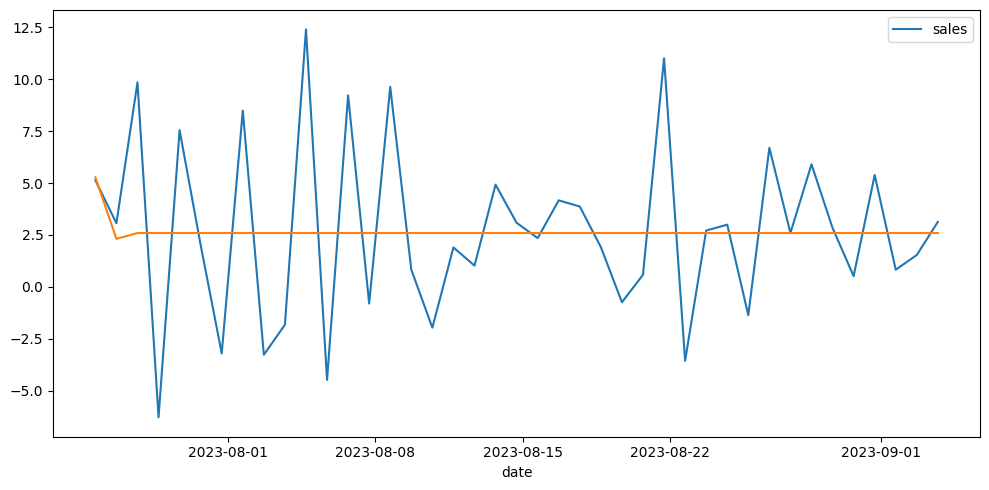

In [17]:
#graficar prediccion con respecto al estacionario
plt.subplots(figsize=(10,5))
sns.lineplot(data=test_df)
sns.lineplot(data=forcast)
plt.tight_layout()
plt.show()

no reconoce bien la variacion, solo reconoce la tendencia crecer en promedio 3 por dia. Esto se debe a que el df es casi lineal y la razon de cambio de algo casi lineal es casi constante y su tasa de cambio sera siempre la misma. la prediccion sera por lo tanto casi lineal.

In [18]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test_df, forcast)

18.33248303965539

In [19]:
from pickle import dump
dump(model, open("../models/time_series_arima.sav", "wb"))

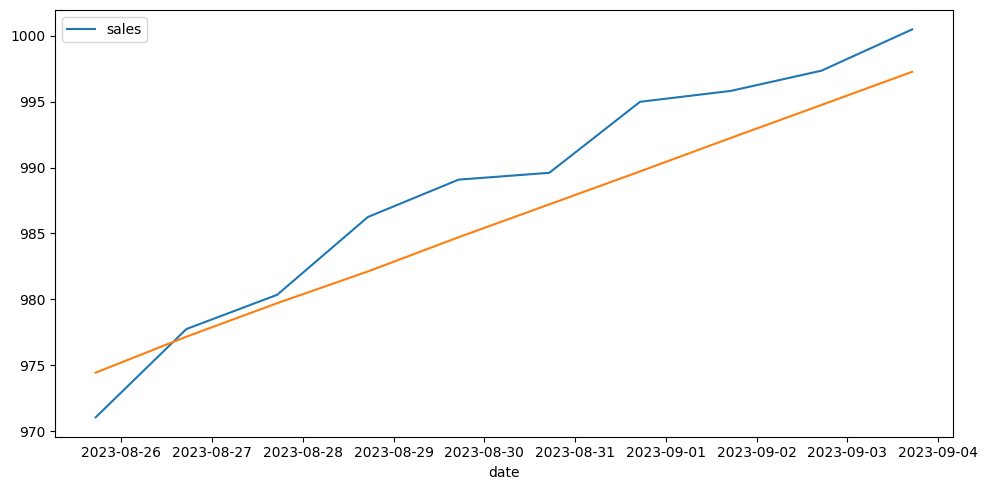

In [21]:
#modelo sobre el data frame no estacionario, para capturar mayor varianza
train_df_2 = df[(df.index > pd.to_datetime('2023-07-25')) & (df.index < pd.to_datetime('2023-08-25'))] 
test_df_2 = df[df.index >= pd.to_datetime('2023-08-25')]

model_2 = auto_arima(train_df_2, seasonal=True, n=7)
forecast_2 = model_2.predict(10)

plt.subplots(figsize=(10,5))
sns.lineplot(data=test_df_2)
sns.lineplot(data=forecast_2)

plt.tight_layout()
plt.show()

In [22]:
#evaluar segundo modelo
mean_squared_error(test_df_2, forecast_2)

11.186617702889981

In [23]:
#guardar segundo modelo
dump(model_2, open("../models/arima_no_estacionario.sav", "wb"))